In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/content/CUSTOMERS.csv")  # Replace with your data file path

# DRop null values
df.dropna(inplace=True)

Xd = df.drop('Loan_Status', axis=1)  # Replace 'Loan_Status' with your actual target column name
X = Xd.drop('Loan_ID',axis=1)
y = df['Loan_Status']



# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Apply label encoding to specific columns in X
X['Gender'] = le.fit_transform(X['Gender'])
X['Married'] = le.fit_transform(X['Married'])
X['Dependents'] = le.fit_transform(X['Dependents'])
X['Education'] = le.fit_transform(X['Education'])
X['Self_Employed'] = le.fit_transform(X['Self_Employed'])
X['Property_Area'] = le.fit_transform(X['Property_Area'])

# Apply label encoding to the target variable separately
y = le.fit_transform(y)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = LogisticRegression().fit(X_train, y_train)

# Define prediction function
def predict_loan_status(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Credit_History, Property_Area, Loan_Amount_Term=360):
    # Create input DataFrame with all required columns
    input_data = pd.DataFrame([[
        Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome,
        CoapplicantIncome, LoanAmount, Credit_History, Property_Area, Loan_Amount_Term
    ]], columns=[
        'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
        'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term',
        'Credit_History', 'Property_Area'
    ])

    # Standardize input data using the previously fitted scaler
    try:
        input_data = scaler.transform(input_data)
    except Exception as e:
        return f"Error in scaling input data: {e}", None

    # Make prediction and get probability
    try:
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[0, 1]  # Probability of "Approved"
    except Exception as e:
        return f"Error in model prediction: {e}", None

    # Return formatted results for Gradio
    return "Approved" if prediction == 1 else "Rejected", round(probability, 2)

# Set up Gradio interface
iface = gr.Interface(
    fn=predict_loan_status,
    inputs=[
        gr.Number(label="Gender (0=Female, 1=Male)"),
        gr.Number(label="Married (0=No, 1=Yes)"),
        gr.Number(label="Dependents (0, 1, 2, or 3)"),
        gr.Number(label="Education (0=Not Graduate, 1=Graduate)"),
        gr.Number(label="Self Employed (0=No, 1=Yes)"),
        gr.Number(label="Applicant Income"),
        gr.Number(label="Coapplicant Income"),
        gr.Number(label="Loan Amount"),
          gr.Number(label="Loan Amount Term"),
        gr.Number(label="Credit History (0=Bad, 1=Good)"),
        gr.Number(label="Property Area (0=Rural, 1=Semiurban, 2=Urban)"),

    ],
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Approval Probability")
    ],
    title="Loan Prediction",
    description="Predict loan approval status based on customer information."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc1d260e060347d042.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# accuracy
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy_linear_regression = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_linear_regression}")

Accuracy: 0.8229166666666666


In [ ]:
# model using random forest
from sklearn.ensemble import RandomForestClassifier # Import Classifier instead of Regressor
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Use RandomForestClassifier
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.8229166666666666


In [ ]:
# model using svm regression
# model using svm regression
from sklearn.svm import SVC # Import SVC for classification instead of SVR
from sklearn.metrics import accuracy_score

svm_model = SVC() # Use SVC classifier
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

SVM Accuracy: 0.8229166666666666


In [ ]:
# model using decision tree regreesion
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")


Decision Tree Accuracy: 0.7291666666666666


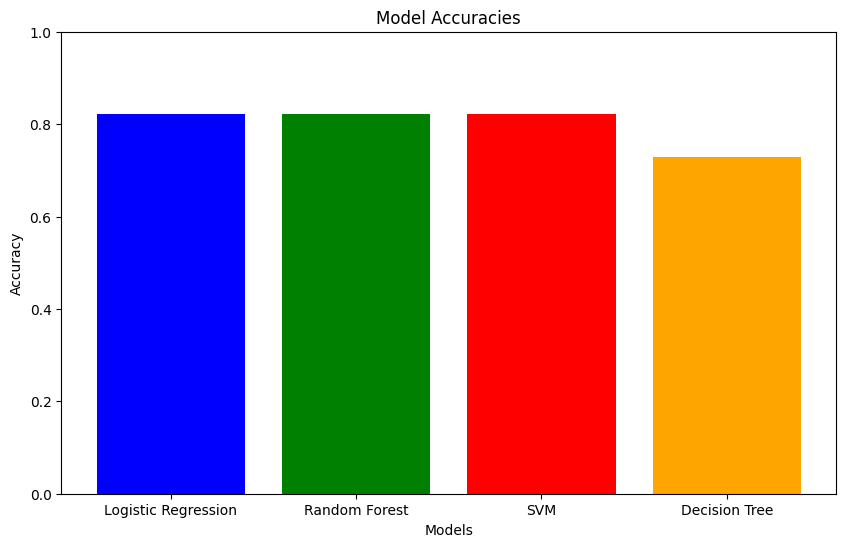

In [ ]:
# plot chart for various various 4 model accuracy
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'SVM', 'Decision Tree']
accuracies = [accuracy_linear_regression, accuracy_rf, accuracy_svm, accuracy_dt]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
plt.show()
